Add Starting Pitching to Model

    In the last notebook we augmented our dataframe to include various features based on the starting pitcher's performance
    Now we will add these features in to see how much improvement we get to our model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
df = pd.read_csv('df_bp5.csv', low_memory=False)

BEGIN MODELING

In [3]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1901) & (df.season<=2015)]
df_valid = df[(df.season>=2016) & (df.season<=2020)]
df_test = df[df.season>=2021]

In [4]:
hv_mean = df_train.home_victory.mean()

FIRST -- Just add in ERA and WHIP over last 35 games (in addition to first model params)

In [5]:
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v', 
]
target = 'home_victory'

In [6]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((52583, 8), (4395, 8), (2244, 8))

In [8]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 28600, number of negative: 23983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 52583, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543902 -> initscore=0.176061
[LightGBM] [Info] Start training from score 0.176061
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.690592
[20]	valid_0's binary_logloss: 0.689613
[30]	valid_0's binary_logloss: 0.688715
[40]	valid_0's binary_logloss: 0.688065
[50]	valid_0's binary_logloss: 0.687341
[60]	valid_0's binary_logloss: 0.686729
[70]	valid_0's binary_logloss: 0.68622
[80]	valid_0's binary_logloss: 0.685815
[90]	valid_0's binary_logloss: 0.685519
[100]	valid_0's binary_logloss: 0.685228
[110]	valid_0's binary_logloss: 0.68493
[120]

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [9]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [10]:
# previous model gave 0.683490243306594
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6788033031905082, 0.6908186491165219)

In [11]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6749355876000072

In [12]:
# naive-LV, naive-simp_mod, naive-current_mod

np.round([.6904 - .6675, .6904-.6830, .6904-.6747], decimals=4)

array([0.0229, 0.0074, 0.0157])

In [13]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

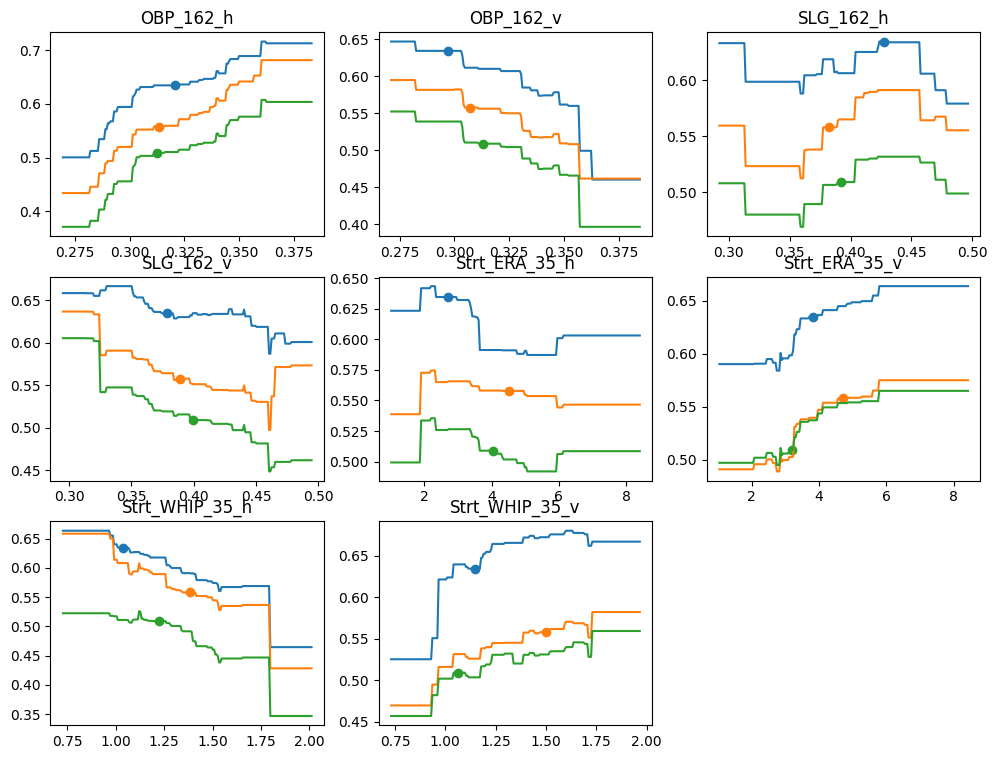

In [14]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

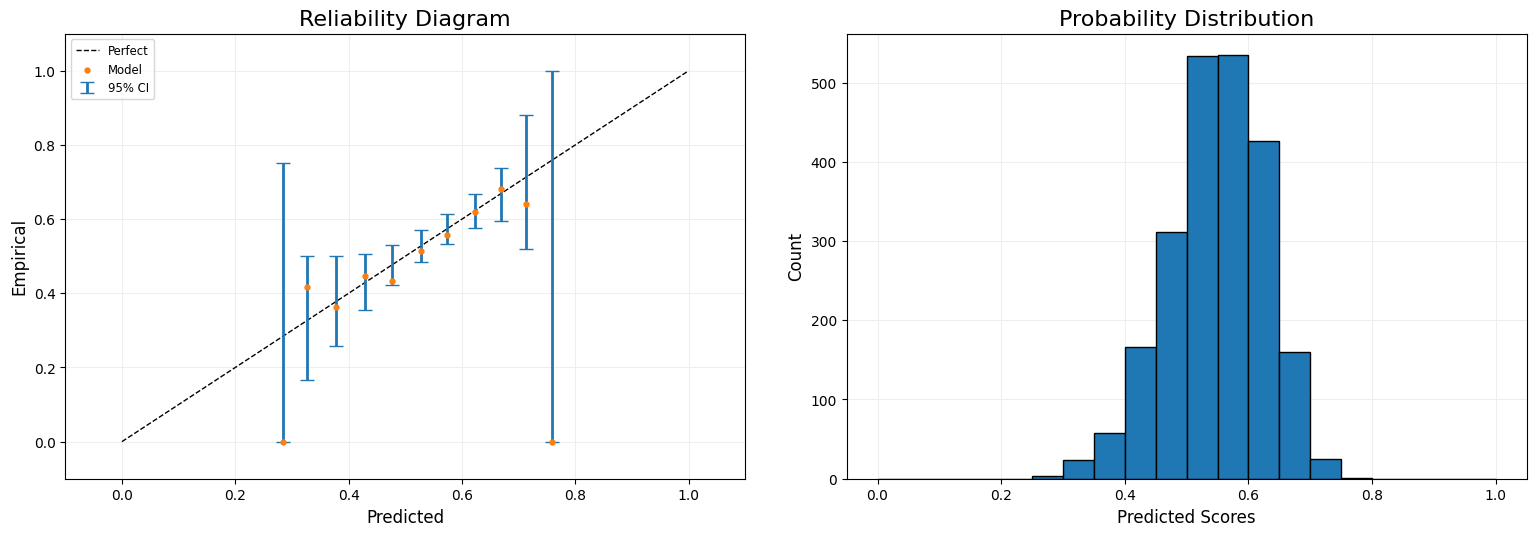

In [15]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [16]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [17]:
# This shows for each game, how the different features affected 

sv_lgbm.head(5).round(3)

,OBP_162_h,OBP_162_v,SLG_162_h,SLG_162_v,Strt_ERA_35_h,Strt_ERA_35_v,Strt_WHIP_35_h,Strt_WHIP_35_v,Intercept
0,-0.023,0.040,0.087,-0.025,0.056,0.058,0.232,0.041,0.179
1,-0.010,0.040,0.080,-0.078,-0.021,-0.029,0.082,-0.134,0.179
2,-0.178,0.021,0.004,-0.082,-0.065,-0.156,-0.004,-0.131,0.179
3,-0.048,0.139,0.006,-0.036,-0.009,0.072,-0.000,0.055,0.179
4,-0.003,-0.084,0.062,-0.073,0.029,-0.049,0.007,-0.083,0.179


In [18]:
df_test.pitcher_start_name_v.iloc[5]

'Kevin Gausman'

In [19]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept         0.179171
Strt_WHIP_35_h    0.095440
OBP_162_h         0.074365
Strt_ERA_35_v     0.070824
OBP_162_v         0.060721
SLG_162_h         0.058519
Strt_WHIP_35_v    0.055946
SLG_162_v         0.046748
Strt_ERA_35_h     0.035864
dtype: float64

Let's add in a few more pitching features...

In [20]:
# Add in SO% and "Modified Slugging Against"

features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
]
target = 'home_victory'

In [21]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [22]:
X_train.shape, X_valid.shape, X_test.shape

((52583, 14), (4395, 14), (2244, 14))

In [23]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 28600, number of negative: 23983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 52583, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543902 -> initscore=0.176061
[LightGBM] [Info] Start training from score 0.176061
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.690516
[20]	valid_0's binary_logloss: 0.689348
[30]	valid_0's binary_logloss: 0.688487
[40]	valid_0's binary_logloss: 0.687647
[50]	valid_0's binary_logloss: 0.686891
[60]	valid_0's binary_logloss: 0.686165
[70]	valid_0's binary_logloss: 0.685605
[80]	valid_0's binary_logloss: 0.68503
[90]	valid_0's binary_logloss: 0.684544
[100]	valid_0's binary_logloss: 0.684173
[110]	valid_0's binary_logloss: 0.683779
[12

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [24]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [25]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6806832001335972, 0.6908186491165219)

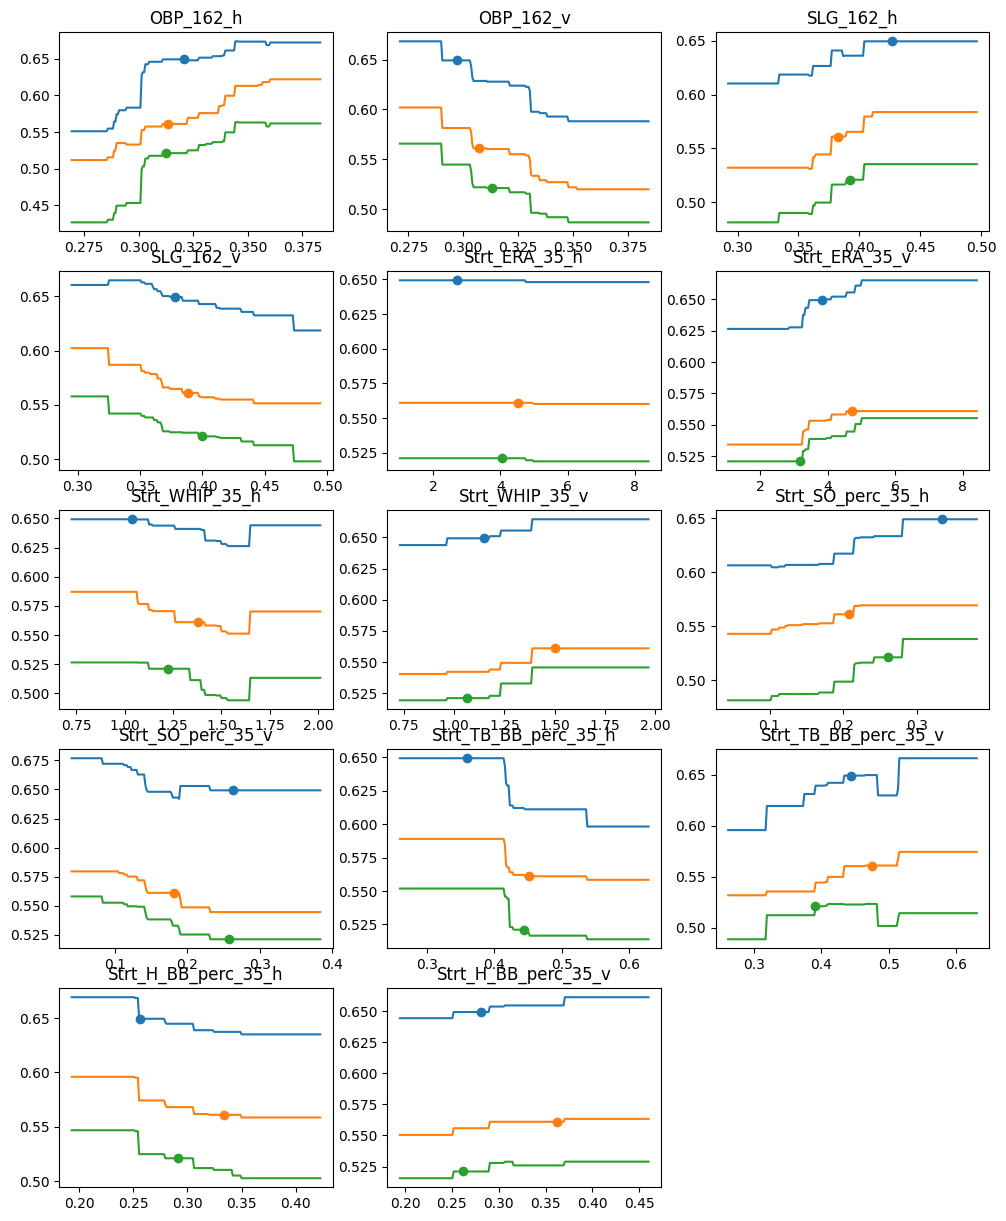

In [26]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

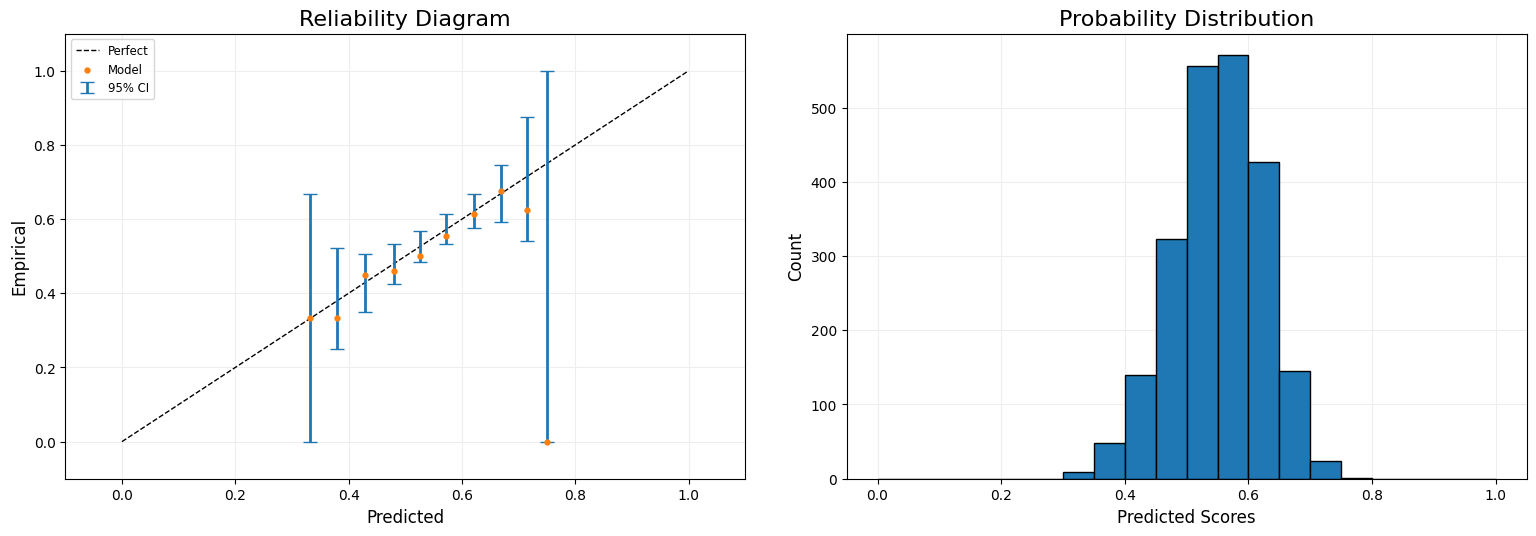

In [27]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [28]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [29]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.178380
Strt_SO_perc_35_h       0.077125
Strt_SO_perc_35_v       0.071340
OBP_162_h               0.057633
Strt_TB_BB_perc_35_h    0.054037
OBP_162_v               0.052570
SLG_162_h               0.047590
Strt_ERA_35_v           0.037332
Strt_WHIP_35_h          0.034795
Strt_TB_BB_perc_35_v    0.032555
SLG_162_v               0.032186
Strt_WHIP_35_v          0.029652
Strt_H_BB_perc_35_h     0.026575
Strt_H_BB_perc_35_v     0.009005
Strt_ERA_35_h           0.002218
dtype: float64

In [30]:
## Let's add in the 10 game lookback features
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_ERA_35_h','Strt_ERA_35_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_SO_perc_35_h', 'Strt_SO_perc_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_ERA_10_h','Strt_ERA_10_v',
            'Strt_WHIP_10_h','Strt_WHIP_10_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Strt_TB_BB_perc_10_h', 'Strt_TB_BB_perc_10_v',
]
target = 'home_victory'

In [31]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [32]:
X_train.shape, X_valid.shape, X_test.shape

((52583, 20), (4395, 20), (2244, 20))

In [33]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 28600, number of negative: 23983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 52583, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543902 -> initscore=0.176061
[LightGBM] [Info] Start training from score 0.176061
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.690451
[20]	valid_0's binary_logloss: 0.689475
[30]	valid_0's binary_logloss: 0.688687
[40]	valid_0's binary_logloss: 0.687941
[50]	valid_0's binary_logloss: 0.68722
[60]	valid_0's binary_logloss: 0.686581
[70]	valid_0's binary_logloss: 0.686032
[80]	valid_0's binary_logloss: 0.685605
[90]	valid_0's binary_logloss: 0.685239
[100]	valid_0's binary_logloss: 0.68488
[110]	valid_0's binary_logloss: 0.684573
[120

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [34]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [35]:
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.6803302743444478, 0.6908186491165219)

In [36]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)

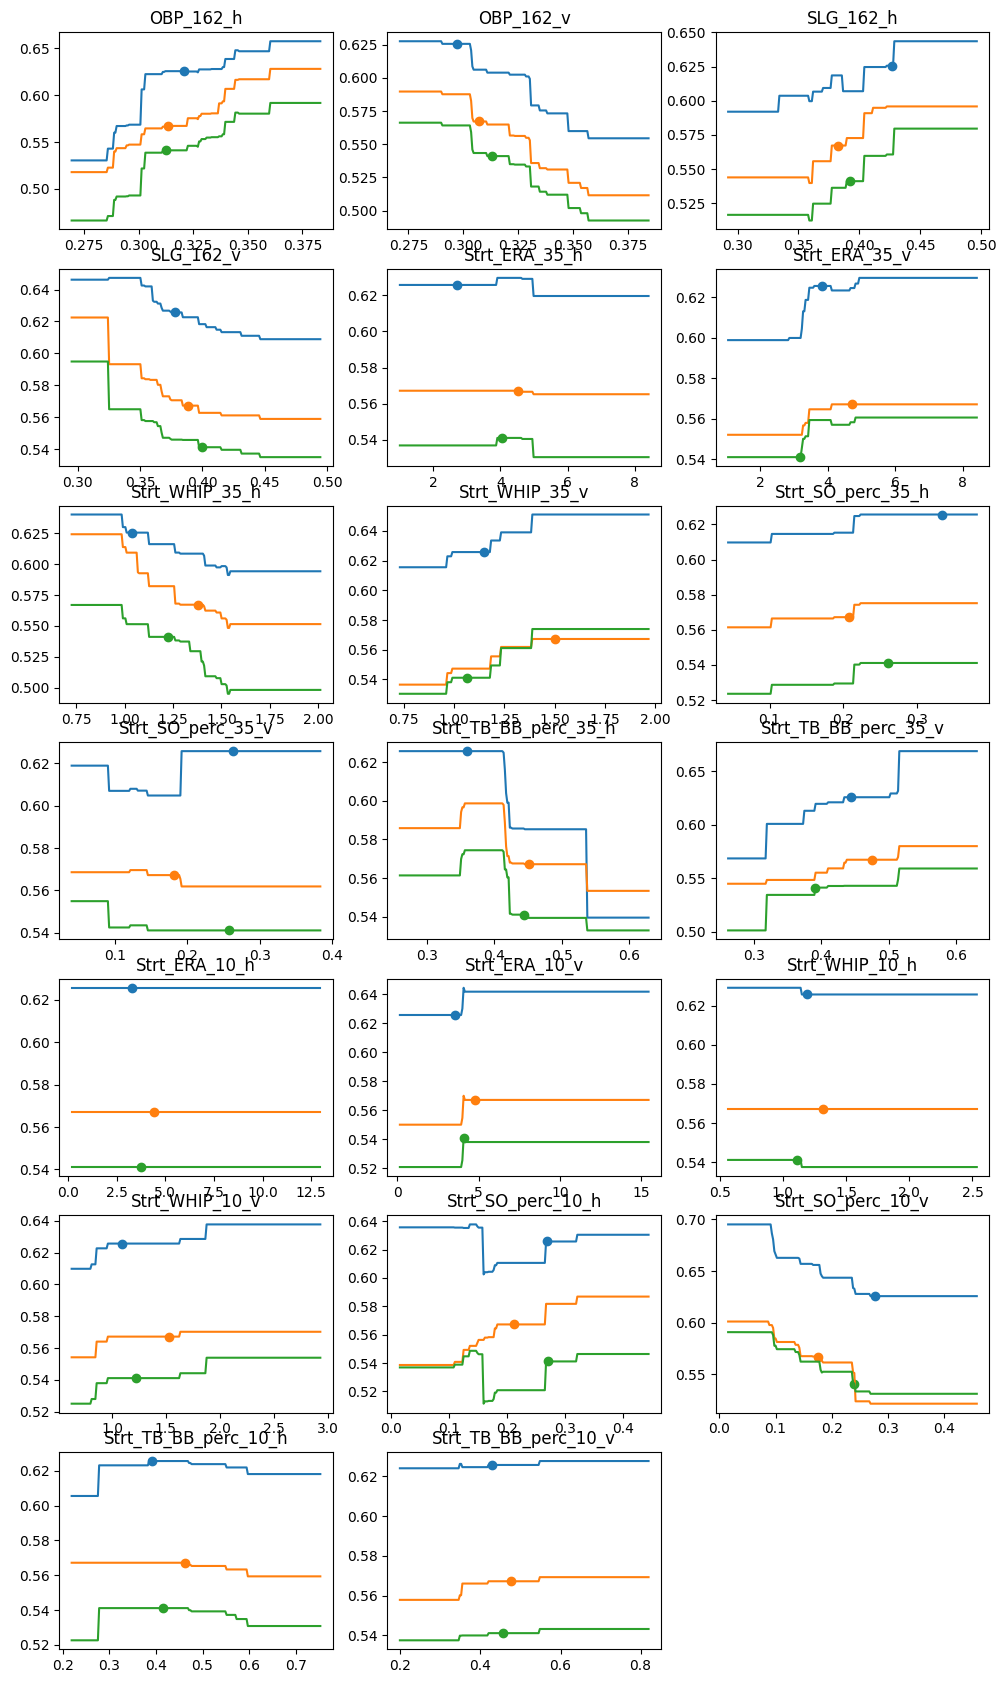

In [37]:
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

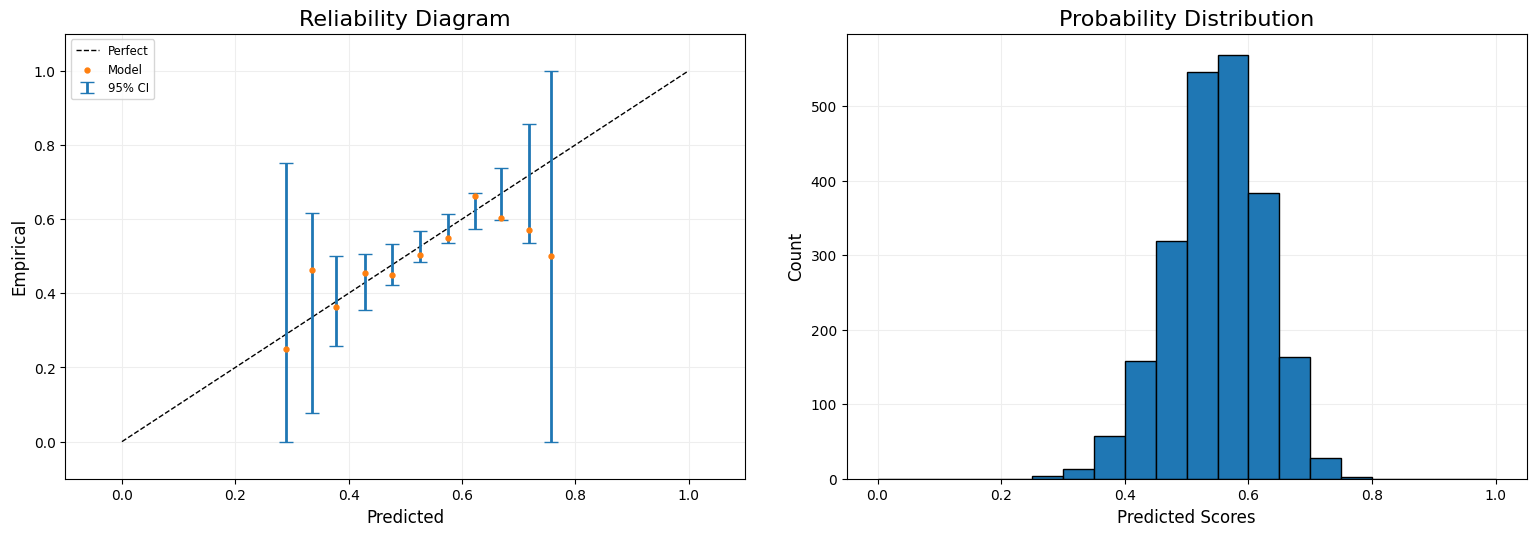

In [38]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [39]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [40]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.178826
Strt_SO_perc_10_v       0.075506
Strt_SO_perc_10_h       0.066076
OBP_162_h               0.055909
Strt_TB_BB_perc_35_h    0.055885
SLG_162_h               0.054593
OBP_162_v               0.053391
Strt_WHIP_35_h          0.052669
SLG_162_v               0.034948
Strt_WHIP_35_v          0.034690
Strt_ERA_35_v           0.030826
Strt_TB_BB_perc_35_v    0.027618
Strt_SO_perc_35_h       0.026181
Strt_ERA_10_v           0.025515
Strt_SO_perc_35_v       0.019759
Strt_TB_BB_perc_10_h    0.006061
Strt_TB_BB_perc_10_v    0.005300
Strt_ERA_35_h           0.005117
Strt_WHIP_10_v          0.004164
Strt_WHIP_10_h          0.003485
Strt_ERA_10_h           0.001111
dtype: float64

In [41]:
# Choose the best window size for each metric, drop ERA
features = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v', 
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            
]
target = 'home_victory'

In [42]:
X_train = df_train.loc[:,features]
X_valid = df_valid.loc[:,features]
X_test = df_test.loc[:,features]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [43]:
X_train.shape, X_valid.shape, X_test.shape

((52583, 10), (4395, 10), (2244, 10))

In [44]:
lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)
lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50), lgbm.log_evaluation(10)])

[LightGBM] [Info] Number of positive: 28600, number of negative: 23983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 52583, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.543902 -> initscore=0.176061
[LightGBM] [Info] Start training from score 0.176061
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.690479
[20]	valid_0's binary_logloss: 0.689463
[30]	valid_0's binary_logloss: 0.688735
[40]	valid_0's binary_logloss: 0.687965
[50]	valid_0's binary_logloss: 0.687237
[60]	valid_0's binary_logloss: 0.686679
[70]	valid_0's binary_logloss: 0.686029
[80]	valid_0's binary_logloss: 0.685568
[90]	valid_0's binary_logloss: 0.685205
[100]	valid_0's binary_logloss: 0.684939
[110]	valid_0's binary_logloss: 0.684594
[1

LGBMClassifier(learning_rate=0.02, max_depth=2, n_estimators=1000)

In [45]:
preds_lgbm = lgbm1.predict_proba(X_test)[:,1]

In [46]:
# now about 4 bps worse than previous model..
log_loss(y_test, preds_lgbm), log_loss(y_test, hv_mean*np.ones(len(y_test)))

(0.680606765645401, 0.6908186491165219)

In [47]:
log_loss(y_test,df_test.implied_prob_h_mid)

0.6749355876000072

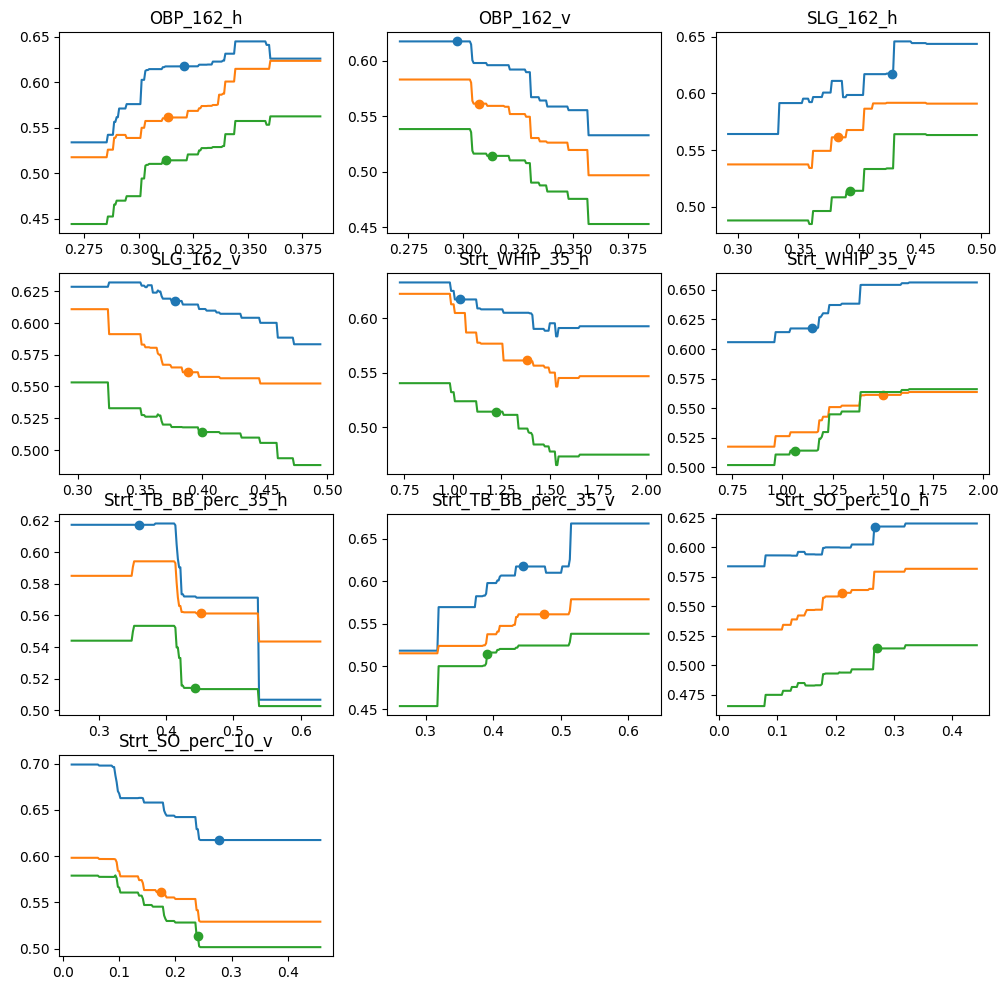

In [48]:
rd = mli.get_range_dict(X_train)
plot_pts = X_test.sample(3, random_state=42)
mli.ice_plot(lgbm1, plot_pts, X_test.columns, mli.get_range_dict(X_train), plots_per_row=3)

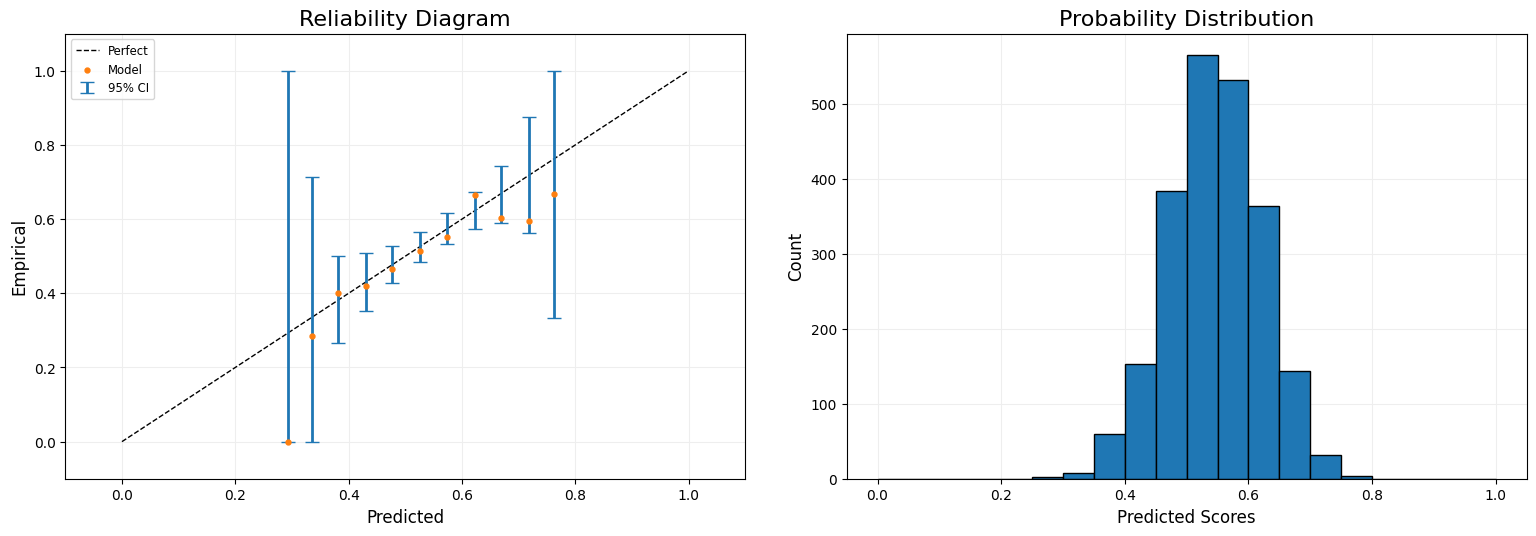

In [49]:
plt.figure(figsize=(16,6))
mli.plot_reliability_diagram(y_test, preds_lgbm, show_histogram=True);

In [50]:
sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
sv_lgbm = pd.DataFrame(sv_lgbm)
sv_lgbm.columns = list(X_test.columns)+['Intercept']

In [51]:
sv_lgbm.abs().mean().sort_values(ascending=False)

Intercept               0.178845
Strt_SO_perc_10_v       0.097663
Strt_SO_perc_10_h       0.081484
Strt_TB_BB_perc_35_h    0.061720
SLG_162_h               0.058125
Strt_WHIP_35_h          0.057342
OBP_162_h               0.056277
Strt_TB_BB_perc_35_v    0.054615
OBP_162_v               0.054486
Strt_WHIP_35_v          0.051753
SLG_162_v               0.033292
dtype: float64

How much do these differences in log loss really mean?

When model A does a few bps better than model B in log loss, how should we think about that?

Is it a meaningful improvement?
How do we know it is not just "luck of the draw" of the test set
We'll run some quick simulations to build our intuition about this.

In [52]:
# Simulate a test set (with given "true" probabilities) and compare two models, 
def ll_dist(probvec_true, probvec_mod1, probvec_mod2, num_trials):
    llvec_mod1 = np.zeros(num_trials)
    llvec_mod2 = np.zeros(num_trials)
    for i in range(num_trials):
        sim_outcome = np.random.binomial(n=1, p=probvec_true)
        llvec_mod1[i] = log_loss(sim_outcome, probvec_mod1)
        llvec_mod2[i] = log_loss(sim_outcome, probvec_mod2)
    return(llvec_mod1 - llvec_mod2)

In [53]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)

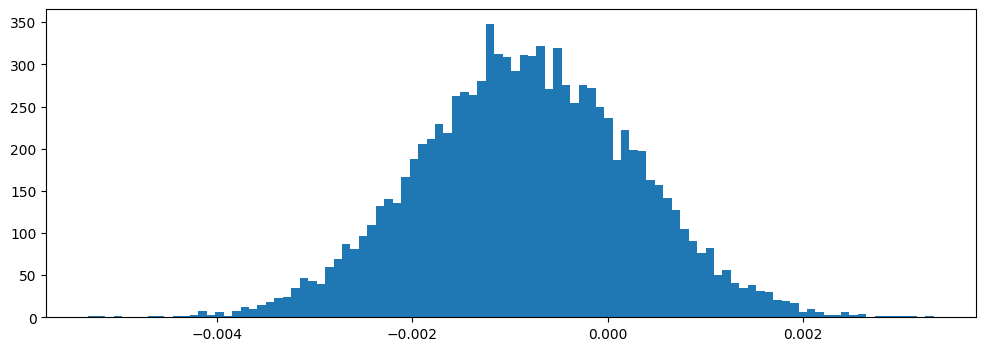

In [54]:
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

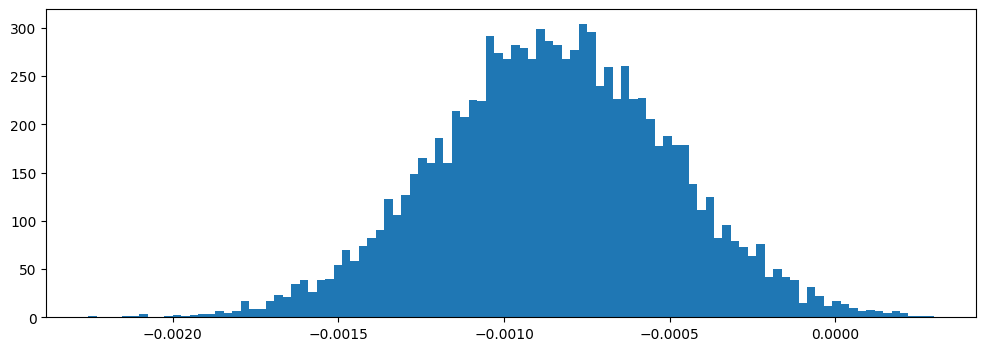

In [55]:
pv_true = np.repeat(df_test.implied_prob_h_mid,10)
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.04, .04, len(pv_true))

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

In [56]:
pv_true = df_test.implied_prob_h_mid
pv_mod1 = pv_true + np.random.uniform(-.02, .02, len(pv_true))
pv_mod2 = pv_true + np.random.uniform(-.10, .10, len(pv_true))

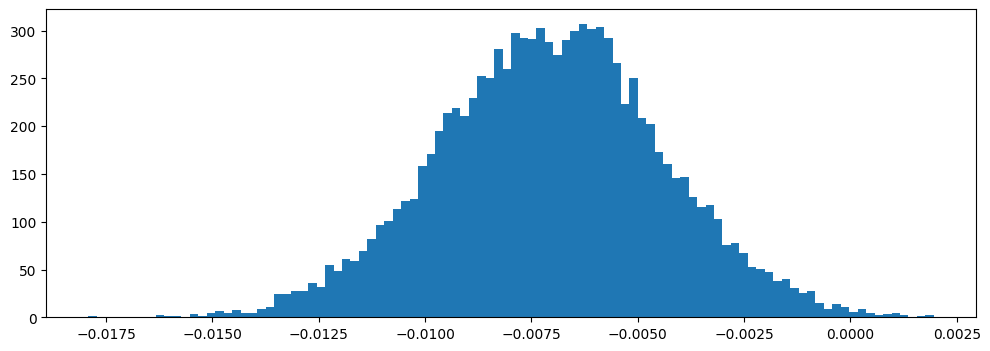

In [57]:

disc = ll_dist(pv_true, pv_mod1, pv_mod2, 10000)
plt.figure(figsize=(12,4))
plt.hist(disc, bins=100);

Conclusions

    - Could be that 5-10 bps improvement is meaningful!
    - Variation due to test set size is considerable
    - Not a simple matter to increase test set size in this problem
    - For now, still need to improve beyond minor optimizations


Potential Next Steps??

    - Have nothing about the quality of the bullpen
    - Bullpen is more meaningful in recent years, as starting pitchers work fewer innings
    - Could cause an issue with "model drift" (something to explore later on)
    - We don't account for the specific hitting lineup (would need individual batter data)
    - We have nothing about fielding
    - Several additional sources of model drift
    - Rule changes about infield positioning
    - Pitching clock
    - NL now has a DH